## 1. Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image


## 2. Import Model and Images

### 2.1 Import Model

In [2]:
model = load_model('../Models/segmentation_model.h5')

### 2.2 Import Images

In [3]:
# Load and preprocess the image
#img_path = 'Resources/images/img_0001.png'
img_path = 'Resources/test_Images/test_image_001.png'  # Replace with the actual path to your image
#img_path = 'Resources/test_Images/test_image_001.png'
img = load_img(img_path, target_size=(384,384))  # Replace height and width with your model's input size
img_array_org = img_to_array(img)
img_array = np.expand_dims(img_array_org, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if required by your model

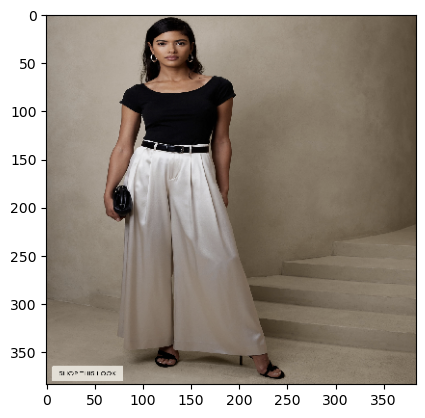

In [4]:
# Display image
plt.imshow(img)

## 3. Make Predictions

In [5]:
# Predict image mask
predicted_mask = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


In [6]:
# Get image mask shape
predicted_mask.shape

(1, 384, 384, 59)

In [7]:
# Use the squeeze fuction to change the image mask shape
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_mask.shape

(384, 384, 59)

In [8]:
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask.shape

(384, 384)

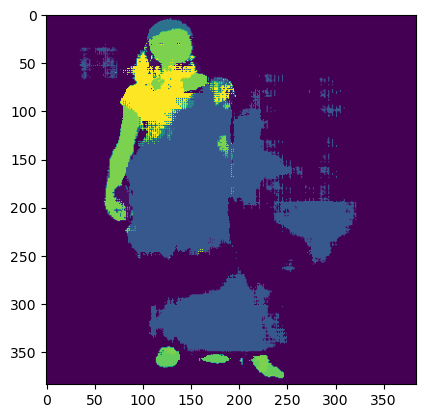

In [9]:
# Display the predicted mask
plt.imshow(predicted_mask, cmap='viridis')  # Use 'viridis' or another colormap for multi-class
plt.show()

In [10]:
# Precicted classes
print(*np.unique(predicted_mask).tolist(),sep=', ')


0, 1, 2, 4, 5, 10, 14, 19, 26, 39, 41, 42, 48, 49, 51


## 4. Get Bounding Boxes of classes

In [11]:
# Create a function to get the bounding boxes
def get_class_bounding_boxes(mask, num_classes):
    """
    Find bounding boxes for each class in the segmentation mask.
    
    Args:
    mask: np.array, shape (height, width), contains class labels for each pixel.
    num_classes: int, number of classes.
    
    Returns:
    bounding_boxes: dict, where keys are class indices and values are bounding boxes (x_min, y_min, x_max, y_max).
    """
    bounding_boxes = {}
    
    for class_idx in range(num_classes):
        # Find all pixels belonging to the current class
        class_mask = (mask == class_idx).astype(np.uint8)

        # Find contours for the class mask
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the bounding box around the largest contour
            x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x + w), max(y_max, y + h)
            
            bounding_boxes[class_idx] = (x_min, y_min, x_max, y_max)

    return bounding_boxes

In [12]:
num_classes = predicted_mask.max() + 1  
bounding_boxes = get_class_bounding_boxes(predicted_mask, num_classes)

# bounding_boxes will now contain the bounding box for each class
for class_idx, box in bounding_boxes.items():
    print(f"Class {class_idx}: Bounding Box {box}")

Class 0: Bounding Box (0, 0, 384, 384)
Class 1: Bounding Box (71, 30, 161, 205)
Class 2: Bounding Box (60, 23, 196, 354)
Class 4: Bounding Box (112, 61, 113, 62)
Class 5: Bounding Box (105, 55, 130, 78)
Class 10: Bounding Box (187, 350, 192, 351)
Class 14: Bounding Box (35, 31, 322, 354)
Class 19: Bounding Box (105, 4, 153, 27)
Class 26: Bounding Box (80, 56, 189, 123)
Class 39: Bounding Box (114, 348, 247, 378)
Class 41: Bounding Box (60, 15, 238, 376)
Class 42: Bounding Box (64, 100, 195, 227)
Class 48: Bounding Box (128, 89, 163, 253)
Class 49: Bounding Box (126, 120, 131, 131)
Class 51: Bounding Box (72, 30, 197, 253)


### 5. Get Labels from Classes

In [13]:
# Import labels from csv file
labels = pd.read_csv('Resources/labels/labels.csv')
# Drop unamed column
labels.drop('Unnamed: 0', axis=1, inplace=True)
# Display labels
labels.head()


,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,belt,other
4,blazer,upper


In [14]:
labels['category'].unique()

array(['other', 'upper', 'shoes', 'head', 'lower'], dtype=object)

In [15]:
# Get label names from bounding_boxes keys
image_labels = labels.iloc[list(bounding_boxes.keys())].reset_index(drop=True)
image_labels

,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,blazer,upper
4,blouse,upper
5,cape,upper
6,dress,upper
7,hair,other
8,jumper,upper
9,shoes,shoes


### 6. Create images from the bounding boxes

In [16]:
images=[]
pixels = []
# Loop through bounding boxes, crop images and save them to disk
for class_idx, box in bounding_boxes.items():
    class_name = labels.iloc[class_idx]['label_list']
    temp_img = img.crop(box)
    images.append(temp_img)
    pixels.append(temp_img.size[0]*temp_img.size[1])

In [17]:
image_labels['pixels'] = pixels
image_labels = image_labels.sort_values(by='pixels', ascending=False)
image_labels

,label_list,category,pixels
0,NaN,other,147456
6,dress,upper,92701
10,skin,other,64258
2,bag,other,45016
14,t-shirt,upper,27875
11,skirt,lower,16637
1,accessories,other,15750
8,jumper,upper,7303
12,sweater,upper,5740
9,shoes,shoes,3990


In [18]:
def get_middle_index(df):
    if len(df)%2 == 0:
        return int(len(df)/2)-1
    else:
        return int((len(df) - 1)/2)

In [19]:
bounding_categories = ['upper', 'lower', 'shoes']
bounding_images = []

In [20]:
for category in bounding_categories:
    # Filter labels based on the category
    filtered_labels = image_labels[(image_labels['category'] == category) & (image_labels['pixels'] > 3000)]
    # If labels exist for the category
    if len(filtered_labels) >= 1:
        # Set label as the middle index
        filtered_labels = filtered_labels.iloc[get_middle_index(filtered_labels)]
        # Save a copy of the image
        images[filtered_labels.name].save(f'Output/images/{category}.png')
        # Add image to list
        bounding_images.append(images[filtered_labels.name])
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/{category}.png')

In [21]:
import os
import base64
import requests
from dotenv import load_dotenv
load_dotenv() 

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = f"Output/images/{bounding_categories[0]}.png"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": "gpt-4o-mini",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": f"{bounding_categories[0]} clothing color, type, length, fit, style. Message should only include these two details"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)


In [22]:
data = response.json()
data

{'id': 'chatcmpl-9yMMp4dbK6tEs9bv6JJkivHLKbL4x',
 'object': 'chat.completion',
 'created': 1724172687,
 'model': 'gpt-4o-mini-2024-07-18',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': '- **Color:** Black  \n- **Type:** Short-sleeve top  ',
    'refusal': None},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 8526,
  'completion_tokens': 16,
  'total_tokens': 8542},
 'system_fingerprint': 'fp_507c9469a1'}

In [23]:
data = response.json()
item = data['choices'][0]['message']['content'].replace('\n',', ')
item

'- **Color:** Black  , - **Type:** Short-sleeve top  '

In [24]:
from serpapi import GoogleSearch

def get_recommendations(item):
    # Load environment variables and API key
    load_dotenv()   
    # Create query for search
    query = f"Shop for Women's sustainable {item}"
    # Search google shopping
    search = GoogleSearch({
        "q": query, 
        "api_key": os.getenv("GOOGLE_SEARCH_API_KEY"),
        "tbm": "shop",  # shop
        #"tbs": "p_ord:rv",
        "num": 100
        })
    # Convert results into a dataframe
    recommendations = pd.DataFrame(search.get_dict()['shopping_results'])

    #recommendations_df.to_csv('search_results/search_results.csv')

    return recommendations

In [25]:
recommendation = get_recommendations(item)

In [26]:
recommendation[(recommendation['rating'] > 4) & (recommendation['reviews'] > 10)]

,position,title,product_link,product_id,serpapi_product_api,source,price,extracted_price,old_price,extracted_old_price,thumbnail,tag,extensions,rating,reviews,delivery,badge
1,2,Garnet Hill Essential Short Sleeve Tee,https://www.google.com/shopping/product/692862...,6928622874484801721,https://serpapi.com/search.json?device=desktop...,Garnet Hill,$39.00,39.00,NaN,NaN,https://encrypted-tbn3.gstatic.com/shopping?q=...,Try-on,"[90-day returns, Try-on]",4.3,507.0,NaN,NaN
6,7,Uniqlo US Women's Open Collar Short-Sleeve Shirt,https://www.google.com/shopping/product/107244...,1072442003729358645,https://serpapi.com/search.json?device=desktop...,Uniqlo,$14.90,14.90,$30,30.0,https://encrypted-tbn2.gstatic.com/shopping?q=...,50% OFFTry-on,"[30-day returns, 50% OFFTry-on]",4.6,171.0,Free $99+,NaN
7,8,Eileen Fisher Women's Organic Pima Cotton Jers...,https://www.google.com/shopping/product/257148...,2571488220282994019,https://serpapi.com/search.json?device=desktop...,Eileen Fisher,$68.00,68.00,NaN,NaN,https://encrypted-tbn1.gstatic.com/shopping?q=...,Try-on,"[Free 30-day returns, Try-on]",4.3,100.0,Free delivery,NaN
9,10,Gap Factory Women's Vintage Crewneck T-Shirt,https://www.google.com/shopping/product/159991...,15999106557626422215,https://serpapi.com/search.json?device=desktop...,Gap Factory,$12.49,12.49,$25,25.0,https://encrypted-tbn2.gstatic.com/shopping?q=...,50% OFFTry-on,"[Free 30-day returns, 50% OFFTry-on]",4.3,12.0,NaN,NaN
10,11,Patagonia Women's Capilene Cool Trail Shirt,https://www.google.com/shopping/product/871724...,8717243947590378029,https://serpapi.com/search.json?device=desktop...,Patagonia,$45.00,45.00,NaN,NaN,https://encrypted-tbn1.gstatic.com/shopping?q=...,Try-on,"[Lifetime returns, Try-on]",4.3,398.0,Free $99+,NaN
12,13,Everlane Women's Organic Cotton V-Neck T-Shirt,https://www.google.com/shopping/product/158067...,15806723161189628295,https://serpapi.com/search.json?device=desktop...,Everlane,$17.00,17.00,$30,30.0,https://encrypted-tbn1.gstatic.com/shopping?q=...,43% OFFTry-on,"[30-day returns, 43% OFFTry-on]",4.4,57.0,NaN,NaN
16,17,Muji USA Women's Hemp and Rayon Short Sleeve B...,https://www.google.com/shopping/product/448641...,448641281467744472,https://serpapi.com/search.json?device=desktop...,muji.us,$49.90,49.90,NaN,NaN,https://encrypted-tbn1.gstatic.com/shopping?q=...,Try-on,"[30-day returns, Try-on]",4.3,29.0,NaN,NaN
18,19,Girlfriend Collective Recycled Cotton Classic ...,https://www.google.com/shopping/product/144545...,14454528076901649143,https://serpapi.com/search.json?device=desktop...,Girlfriend Collective,$29.40,29.40,$42,42.0,https://encrypted-tbn1.gstatic.com/shopping?q=...,30% OFF,"[30-day returns, 30% OFF]",4.6,41.0,Free $100+,NaN
21,22,Everlane Women's Box-Cut T-Shirt,https://www.google.com/shopping/product/114225...,11422563236278624282,https://serpapi.com/search.json?device=desktop...,Everlane,$30.00,30.00,NaN,NaN,https://encrypted-tbn3.gstatic.com/shopping?q=...,Try-on,"[30-day returns, Try-on]",4.7,677.0,NaN,NaN
23,24,Vuori Women's Mudra Fitted Tee,https://www.google.com/shopping/product/947775...,9477757543694555819,https://serpapi.com/search.json?device=desktop...,REI,$58.00,58.00,NaN,NaN,https://encrypted-tbn3.gstatic.com/shopping?q=...,NaN,[90-day returns],4.7,727.0,NaN,NaN


In [27]:
recommendation['thumbnail'][0]

'https://encrypted-tbn0.gstatic.com/shopping?q=tbn:ANd9GcTPtTNLtd8eX0h58uctgZcm22l2XMqyp5MG4RVWxrHBdjn9MBYKbyrL_f8uFD8uHUJ2zsB3B3J2a0apZbnECnUCF3t52udsinqBaYZZXiQ'